## Setup and Import

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from joblib import dump, load

import plotly.express as px

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
churn = pd.read_csv('../data/trunc_churn.csv')
members = pd.read_csv('../data/trunc_members.csv')
transactions = pd.read_csv('../data/trunc_transaction.csv')
users = pd.read_csv('../data/trunc_users.csv')

merged_df = churn.merge(members, on='msno'
         ).merge(transactions, on='msno'
         ).merge(users, on='msno').set_index('msno')

In [3]:
print(churn.shape)        # 20,000 users
print(members.shape)      # 17,600 users
print(transactions.shape) # 19,216 users, each line is a transaction
print(users.shape)        # 15,457 users, each line is a listening session
print(merged_df.shape)    # 148,48 users, each line varies

(20000, 2)
(17660, 6)
(23588, 9)
(277101, 9)
(335947, 22)


## Imputation

In [4]:
# convert missing/junk ages to 0
merged_df.loc[merged_df.bd <= 0, 'bd'] = np.nan
merged_df.loc[merged_df.bd > 100, 'bd'] = np.nan

In [5]:
# numerically encode gender
merged_df.loc[merged_df.gender == 'female', 'gender'] = 1
merged_df.loc[merged_df.gender == 'male', 'gender'] = 0

# convert dtype from object to float for imputer
merged_df.gender = merged_df.gender.astype(float)

In [6]:
merged_df = merged_df.rename(columns={'gender': 'is_female',
                        'bd': 'age',
                        'date': 'listen_date'})

In [7]:
# group merged_df by user for imputing user age and gender
df = merged_df.groupby('msno').mean()

# KNN is distance-based so data must be temporarily scaled
scaler = MinMaxScaler()
scaler_fitted = scaler.fit(df)
scaled_merged_df = pd.DataFrame(scaler_fitted.transform(df),
                         index=df.index, columns=df.columns)

In [8]:
# # impute scaled user-grouped df
# imputer = KNNImputer(n_neighbors=round(np.sqrt(len(merged_df))))
# imputed_array = imputer.fit_transform(scaled_merged_df)
# dump(imputed_array, '../data/imputed_array.pkl')

# undo scaling
imputed_array = load('../data/imputed_array.pkl')
inverse_array = scaler_fitted.inverse_transform(imputed_array)
imputed_merged_df = \
    pd.DataFrame(inverse_array,
                 index=df.index, columns=df.columns)

In [9]:
# classify predictions as female or male using 50% threshold
imputed_merged_df.loc[imputed_merged_df.is_female >= 0.5, 'is_female'] = 1
imputed_merged_df.loc[imputed_merged_df.is_female < 0.5, 'is_female'] = 0

In [10]:
# convert age from float to int
imputed_merged_df.age = imputed_merged_df.age.apply(lambda x: round(x))

In [11]:
# merge imputed columns
merged_df = merged_df.drop(['age', 'is_female'], axis=1
       ).merge(imputed_merged_df[['age', 'is_female']],
         how='left', left_index=True, right_index=True)

## Pre-Processing

In [12]:
date_cols = ['registration_init_time', 'transaction_date',
             'membership_expire_date', 'listen_date']

# change date cols to datetime dtype
for col in date_cols:
    merged_df[col] = pd.to_datetime(merged_df[col], format='%Y%m%d')

In [13]:
categorical_cols = ['city', 'registered_via', 'payment_method_id']
bool_cols = ['is_churn', 'is_female', 'is_auto_renew', 'is_cancel']

# change numeric cols that represent categorical data to object dtype
for col in categorical_cols + bool_cols:
    merged_df[col] = merged_df[col].astype(str)

## Dataframe by User

### Pre-processing:
- Includes 4 engineered features to sub for date cols when grouping by user:
    - num_transactions: sub for transaction_date
    - num_sessions: sub for listen_date
    - membership_duration: sub for registration_init_time
    - days_to_expiration: sub for membership_expire_date

In [14]:
transactions = pd.read_csv('../data/trunc_transaction.csv', index_col='msno')
merged_df['num_transactions'] = \
    transactions.groupby('msno').transaction_date.count()
merged_df.num_transactions.fillna('0', inplace=True)

In [15]:
users = pd.read_csv('../data/trunc_users.csv', index_col='msno')
merged_df['num_sessions'] = \
    users.groupby('msno').date.count()
merged_df.num_sessions.fillna('0', inplace=True)

In [16]:
# comes from most recent transaction?
# makes the assumption that membership is continuous
merged_df['membership_duration'] = \
    (merged_df.membership_expire_date - merged_df.registration_init_time
    ).astype('timedelta64[D]')

In [17]:
merged_df['days_to_expiration'] = \
    (merged_df.membership_expire_date - merged_df.transaction_date
    ).astype('timedelta64[D]')

### Groupby MSNO

In [18]:
# this groupby takes a while

# by_msno = merged_df.groupby('msno').mean()

# single_value_cols = \
#     merged_df[categorical_cols + bool_cols].groupby('msno').max()

# by_msno = by_msno.merge(single_value_cols, how='left',
#                         left_index=True, right_index=True);

# dump(by_msno, '../data/by_msno.pkl')

In [19]:
by_msno = load('../data/by_msno.pkl')

In [20]:
by_msno.payment_plan_days = round(by_msno.payment_plan_days)

In [21]:
by_msno.rename(columns={
    'payment_plan_days' : 'payment_plan_days_per_transaction_avg',
    'plan_list_price'   : 'plan_list_price_per_transaction_avg',
    'actual_amount_paid': 'actual_amount_paid_per_transaction_avg',
    'num_25' : 'num_25_per_session_avg',
    'num_50' : 'num_50_per_session_avg',
    'num_75' : 'num_75_per_session_avg',
    'num_985': 'num_985_per_session_avg',
    'num_100': 'num_100_per_session_avg',
    'num_unq': 'num_unq_per_session_avg',
    'total_secs': 'total_secs_per_session'}, inplace=True);

### 30-Day Plans Subset

In [22]:
# most users are on 30-day plans
print(round(
    by_msno.payment_plan_days_per_transaction_avg.value_counts().values[0]
    / len(by_msno) * 100), 'percent of users are on 30-day plans')
print('', round(
    by_msno.payment_plan_days_per_transaction_avg.value_counts().iloc[1:,
    ].sum() / len(by_msno) * 100), 'percent of users are on other plans')

# drop all other plans from df
subset = by_msno.loc[by_msno.payment_plan_days_per_transaction_avg == 30]

97 percent of users are on 30-day plans
 3 percent of users are on other plans


In [23]:
# most users are on auto-renew plans
print(round(
    subset.is_auto_renew.value_counts().values[0]
    / len(by_msno) * 100), 'percent of users are on auto-renew plans')
print('', round(
    subset.is_auto_renew.value_counts().iloc[1:,].sum() / len(by_msno) * 100),
    'percent of users do not have auto-renew')

# drop all plans that don't auto-renew from df
# subset = subset.loc[subset.is_auto_renew == '1']

89 percent of users are on auto-renew plans
 9 percent of users do not have auto-renew


In [24]:
# 98% of users with 30-day plans have only one of 5 payment plans
price_values = subset.plan_list_price_per_transaction_avg.value_counts()
prices = subset.plan_list_price_per_transaction_avg.value_counts().index

for i in np.arange(0, 6):
    print(round(price_values.iloc[i] / len(subset) * 100),
          f'percent of users pay ${round(prices[i])}')
    
# drop all other plans from df
subset = subset.loc[subset.plan_list_price_per_transaction_avg.isin(prices[:5])]

49 percent of users pay $149
31 percent of users pay $99
11 percent of users pay $180
4 percent of users pay $129
3 percent of users pay $100
0 percent of users pay $150


In [25]:
# subset.to_csv('../data/by_msno.csv')

In [57]:
px.imshow(subset.astype(float).corr(), x=subset.astype(float).corr().columns, y=subset.astype(float).corr().index)

## Dataframe by Plans

In [26]:
# set bool cols to int to get percentages for plans df
subset[bool_cols] = subset[bool_cols].astype(float).astype(int)

plans = subset.groupby('plan_list_price_per_transaction_avg').mean()

In [27]:
# add cols left out of groupby_mean to plans df
mode_cols = subset.columns.difference(plans.columns).to_list()
mode_df = subset.groupby('plan_list_price_per_transaction_avg'
                        )[mode_cols].agg(lambda x: x.value_counts().index[0])
plans = plans.merge(mode_df, left_index=True, right_index=True)

In [28]:
plans.index.name = 'plan_list_price'
plans.rename(columns={
    'age' : 'user_age_avg',
    'num_transactions'   : 'num_transactions_avg',
    'num_sessions': 'num_sessions_avg',
    'membership_duration' : 'membership_duration_avg',
    'days_to_expiration' : 'days_to_expiration_avg',
    'city' : 'city_mode',
    'is_auto_renew': 'is_auto_renew_percent',
    'is_cancel': 'is_cancel_percent',
    'is_churn': 'is_churn_percent',
    'is_female': 'is_female_percent',
    'payment_method_id': 'payment_method_id_mode',
    'registered_via': 'registered_via_mode'}, inplace=True)

plans.drop(['payment_plan_days_per_transaction_avg',
            'actual_amount_paid_per_transaction_avg',
            'plan_list_price_per_transaction_avg'],
           axis=1, inplace=True)

### Feature Engineering

In [29]:
# add share of users per plan
plans['num_users'] = \
    subset.reset_index().groupby(['plan_list_price_per_transaction_avg']
                                ).msno.count()

plans['num_users_share'] = plans.num_users / plans.num_users.sum()

In [30]:
plans.num_users_share

plan_list_price
99.0     0.316634
100.0    0.033493
129.0    0.039052
149.0    0.498522
180.0    0.112299
Name: num_users_share, dtype: float64

In [31]:
# add share of total churn per plan
plans['num_is_churn'] = plans.num_users * plans.is_churn_percent

plans['is_churn_share'] = plans.num_is_churn / plans.num_is_churn.sum()

#### Revenue by Churn

In [32]:
# gross revenue per plan
plans['gross_revenue_amount'] = plans.index * plans.num_users
print('Gross revenue:\n', plans.gross_revenue_amount, '\n')

# amount of revenue lost to churn per plan
plans['is_churn_amount'] = plans.gross_revenue_amount * plans.is_churn_percent
print('Revenue lost to churn:\n', plans.is_churn_amount, '\n')

# net revenue per plan
plans['net_revenue_amount'] = \
    plans.gross_revenue_amount * (1 - plans.is_churn_percent)
print('Net revenue:\n', plans.net_revenue_amount)

Gross revenue:
 plan_list_price
99.0      445500.0
100.0      47600.0
129.0      71595.0
149.0    1055665.0
180.0     287280.0
Name: gross_revenue_amount, dtype: float64 

Revenue lost to churn:
 plan_list_price
99.0     10494.0
100.0      500.0
129.0     3741.0
149.0    48723.0
180.0    21240.0
Name: is_churn_amount, dtype: float64 

Net revenue:
 plan_list_price
99.0      435006.0
100.0      47100.0
129.0      67854.0
149.0    1006942.0
180.0     266040.0
Name: net_revenue_amount, dtype: float64


In [33]:
# percent gross revenue per plan
plans['gross_revenue_percent'] = \
    plans.gross_revenue_amount / plans.gross_revenue_amount.sum()

In [34]:
# percent net revenue per plan: gross minus churn
plans['net_revenue_percent'] = \
    plans.gross_revenue_percent * (1 - plans.is_churn_percent)

In [35]:
# do annual amounts to factor in loss month-after-month

#### Churn

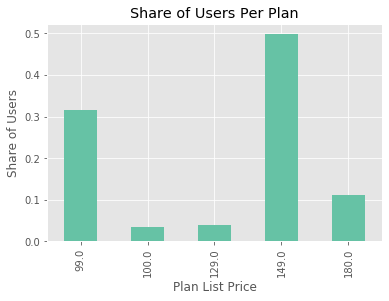

In [36]:
ax = plans.num_users_share.plot(title='Share of Users Per Plan',
                                 kind='bar', grid=True, colormap='Set2')
ax.set_xlabel('Plan List Price')
ax.set_ylabel('Share of Users')
plt.savefig('../images/share_users_plan.png', bbox_inches = "tight");

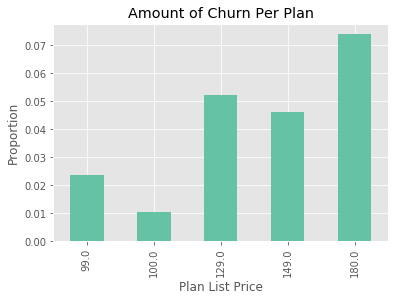

In [37]:
ax = plans.is_churn_percent.plot(title='Amount of Churn Per Plan',
                                 kind='bar', grid=True, colormap='Set2')
ax.set_xlabel('Plan List Price')
ax.set_ylabel('Proportion')
plt.savefig('../images/amount_churn_plan.png', bbox_inches = "tight");

- Although the $\$$180 plan has the highest amount of churn (above), it has the 2nd greatest share of churn among all plans (below), meaning it affects revenue less than the $\$$149 plan even though the $\$$149 plan has less churn.

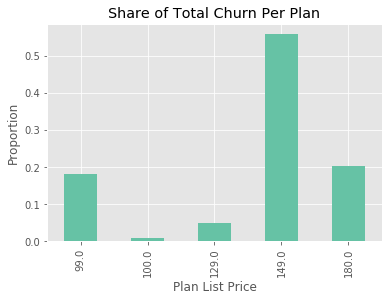

In [38]:
# represents the gap between bars in the chart below
ax = plans.is_churn_share.plot(title='Share of Total Churn Per Plan',
                                 kind='bar', grid=True, colormap='Set2')
ax.set_xlabel('Plan List Price')
ax.set_ylabel('Proportion')
plt.savefig('../images/share_churn_plan.png', bbox_inches = "tight");

- This difference is shown below. The plan with the highest churn actually results in 4% LESS revenue loss.
- Therefore, if KKBox wanted the greatest reduction in financial loss, churn should be minimized specifically for the customers on the $\$$149 plan, because they make up the vast majority of users.

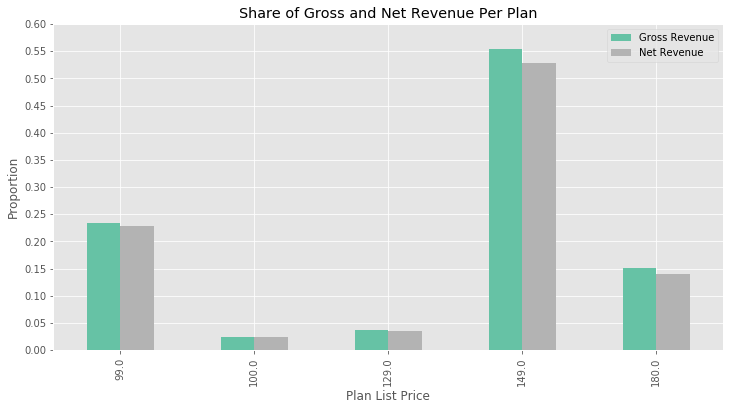

In [39]:
ax = plans[['gross_revenue_percent', 'net_revenue_percent'
           ]].plot(title='Share of Gross and Net Revenue Per Plan',
                   kind='bar', figsize=(12, 6), grid=True, colormap='Set2',
                   yticks=np.arange(0, 0.625, 0.05))
ax.set_xlabel('Plan List Price')
ax.set_ylabel('Proportion')
ax.legend(['Gross Revenue', 'Net Revenue'])
plt.savefig('../images/revenue_share.png', bbox_inches = "tight");

In [40]:
# plans.to_csv('../data/plans.csv')

In [47]:
len(subset) / len(merged_df.groupby('msno')) * 100

95.7165948275862